In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### **Algoritmos a probar**

**Linear**
* Logistic Regression
* Linear SVC (regularized - unregularized)

**Non-linear**
* Poly SVC
* rbf SVC

**otros**
* naïve Bayes
* Nearest Neighbors Classification
* Stochastic Gradient Descent
* Gaussian Process Classification
* Decision Trees

**Ensambles**
* Random Forests
* AdaBoost
* Gradient Tree Boosting

**Neural Network**
* Multi-layer Perceptron

### Pre-procesamiento de datos

In [2]:
# Cargo datos parte1
avisos_parte1 =  pd.read_csv('../data/datos_navent_fiuba/fiuba_6_avisos_detalle.csv')
postulaciones_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_4_postulaciones.csv')
vistas_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_3_vistas.csv')
edadYGenero_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_2_postulantes_genero_y_edad.csv')
educacion_parte1 = pd.read_csv('../data/datos_navent_fiuba/fiuba_1_postulantes_educacion.csv')

# Cargo datos hasta 15_4
avisos_hasta15_4 =  pd.read_csv('./data/Fiuba hasta 15 Abril/fiuba_6_avisos_detalle.csv')
postulaciones_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_4_postulaciones.csv')
vistas_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_3_vistas.csv')
edadYGenero_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_2_postulantes_genero_y_edad.csv')
educacion_hasta15_4 = pd.read_csv('data/Fiuba hasta 15 Abril/fiuba_1_postulantes_educacion.csv')

# Concateno la info
avisos = pd.concat([avisos_parte1, avisos_hasta15_4])
postulaciones = pd.concat([postulaciones_parte1, postulaciones_hasta15_4])
vistas = pd.concat([vistas_parte1, vistas_hasta15_4])
edadYGenero = pd.concat([edadYGenero_parte1, edadYGenero_hasta15_4])
educacion = pd.concat([educacion_parte1, educacion_hasta15_4])

# Elimino df innecesarios
del(avisos_hasta15_4,
    avisos_parte1,
    postulaciones_hasta15_4,
    postulaciones_parte1,
    vistas_hasta15_4,
    vistas_parte1,
    edadYGenero_hasta15_4,
    edadYGenero_parte1,
    educacion_hasta15_4,
    educacion_parte1)

# Guardo una lista con los datasets
data = [avisos, postulaciones, vistas, edadYGenero, educacion]

# Reseteo los index
for df in data:
  df.reset_index(drop=True, inplace=True)

# Elimino duplicados
for df in data:
  if(df.duplicated().any().any()):
    df.drop_duplicates(inplace=True)

# Remuevo columnas innecesarias
avisos.drop(columns=['idpais','ciudad','mapacalle'], inplace=True)

# Renombro columnas
educacion.rename(columns={'nombre':'nivel'}, inplace=True)
vistas.rename(columns={'idAviso':'idaviso','timestamp':'fechavista'}, inplace=True)

In [3]:
# Veo que set y columnas tiene datos faltantes
datos = {'avisos': avisos, 'postulaciones': postulaciones, 'vistas': vistas, 'edadYGenero': edadYGenero, 'educacion': educacion}
for name, df in datos.items():
  cols_con_nulls = df.isnull().any()
  print(f"[{name}]",cols_con_nulls.any())
  if cols_con_nulls.any():
    cols = df.columns[cols_con_nulls.values][0]
    print('  columnas ->',cols)
    for column in [cols]:
      print(f'  tasa[{column}]:', len(df[df[[column]].isnull().values])/len(df))
  print()

[avisos] True
  columnas -> denominacion_empresa
  tasa[denominacion_empresa]: 0.0003048006096012192

[postulaciones] False

[vistas] False

[edadYGenero] True
  columnas -> fechanacimiento
  tasa[fechanacimiento]: 0.04809377846111661

[educacion] False



In [4]:
# AVISOS
# Analizo cols con nulls
if(avisos.isna().any().any()):
  cols_con_nulls = avisos.columns[avisos.isna().any().values]
  for col in cols_con_nulls:
    print(col)
    print(avisos[col].isna().value_counts())

# Elimino filas con datos faltantes
if(avisos.isna().any().any()):
  avisos.dropna(inplace=True)

denominacion_empresa
False    19679
True         6
Name: denominacion_empresa, dtype: int64


In [5]:
# AVISOS.DESCRIPCIÓN
# Función para extraer tags html
import re, string, unicodedata
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub(' ', text)
# Función para reemplazar diacríticos
#def replace_diacritics(text):
#  return unicodedata.normalize('NFKD',text).encode('ASCII', 'ignore').decode()

# Mapea signos (.,:!¡¿?@ etc) a None
tr = str.maketrans('', '', string.punctuation)

# Remuevo tags html, caracteres especiales, espacios, diacríticos
avisos['descripcion'] = avisos.descripcion.apply(lambda w: remove_tags(w)
                                                 .replace('\r\n',' ')
                                                 .replace('\xa0',' ')
                                                 .translate(tr)
                                                 .lower()
                                                 .strip())
avisos.descripcion.sample()

3483    nos encontramos en la búsqueda de supervisor l...
Name: descripcion, dtype: object

In [6]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, HashingVectorizer
from stop_words import get_stop_words

stop_words = get_stop_words('es')

# Elegir uno HashingTrick/TF-IDF_Vectorizer
# n_features para elegir la cantidad de cols
hash_vectorizer = make_pipeline(HashingVectorizer(), TfidfTransformer())
X = hash_vectorizer.fit_transform(avisos.descripcion.values)
#tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
#X = tfidf_vectorizer.fit_transform(avisos.descripcion.values)
#print(tfidf_vectorizer.vocabulary_)
#print(tfidf_vectorizer.idf_)
print(X.shape)
X

(19679, 1048576)
CPU times: user 4.52 s, sys: 26.1 ms, total: 4.55 s
Wall time: 4.56 s


k: 2 | cost: 17149.80164034698
k: 3 | cost: 16711.102668519095
k: 4 | cost: 16830.091506401615
k: 5 | cost: 16476.290170612614
k: 6 | cost: 16414.90800604861
k: 7 | cost: 16394.83803914569
k: 8 | cost: 16319.371428476337
k: 9 | cost: 16264.506964575296
k: 10 | cost: 16248.521097945997
k: 11 | cost: 16230.048410216543
k: 12 | cost: 16228.025175078383
k: 13 | cost: 16174.322202101685
k: 14 | cost: 16188.247150043386
k: 15 | cost: 16134.474921372326
k: 16 | cost: 16096.367820202348
k: 17 | cost: 16100.966353338743
k: 18 | cost: 16059.774378502607
k: 19 | cost: 16068.090666347973
k: 20 | cost: 16046.058413573872


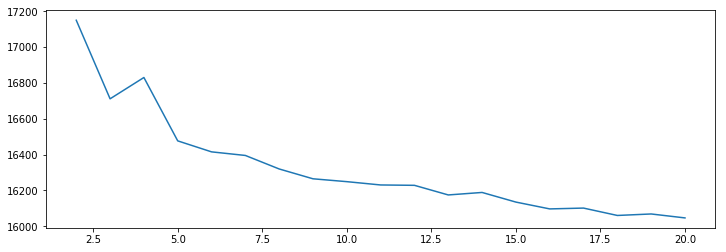

CPU times: user 5min 52s, sys: 3.37 s, total: 5min 55s
Wall time: 5min 56s


In [7]:
%%time
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans

#hc = AgglomerativeClustering()
#hc
clusters = []
costs = []
for n_clusters in range(2,21):
  #model = KMeans(n_clusters=n_clusters, n_jobs=-2)
  model = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10000)
  model.fit(X)
  clusters.append(n_clusters)
  costs.append(model.inertia_)
  print('k:',n_clusters,'| cost:', model.inertia_)
plt.figure(figsize=(12,4))
plt.plot(clusters,costs)
plt.show()

In [8]:
%%time
mbkm_model = MiniBatchKMeans(n_clusters=7, batch_size=10000)
mbkm_model.fit(X)

CPU times: user 11.2 s, sys: 163 ms, total: 11.3 s
Wall time: 11.3 s


In [9]:
pd.get_dummies(mbkm_model.labels_).rename(columns=(dict([(n,f'desc_{n+1}') for n in range(7)]))).head(4)

,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1


In [ ]:
# Tarda casi 40 min
%%time
km_model = KMeans(n_clusters=7, n_jobs=-2)
km_model.fit(X)

In [ ]:
pd.get_dummies(km_model.labels_).rename(columns=(dict([(n,f'desc_{n+1}') for n in range(7)]))).head(4)

In [7]:
#from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
#dist = 1 - cosine_similarity(X)
#dist = cosine_distances(X)
#dist

In [6]:
# EDUCACIÓN
# Analizo valores
nivel_counts = educacion.nivel.value_counts()
print('[nivel]')
for val in nivel_counts.index:
  print(val,' '*(17-len(val)),nivel_counts[val],' '*(7-len(str(nivel_counts[val]))),nivel_counts[val]/len(educacion))

# Reemplazo valor 'Otro' por valor moda
mode = educacion.nivel.mode()[0]
educacion.nivel.replace('Otro', mode, inplace=True)
print()
print('[estado]')
print(educacion.estado.value_counts())

# Convierto valores categóricos a columnas booleanas
nivel = {
  'Doctorado': 6,
   'Master': 5,
   'Posgrado': 4,
   'Universitario': 3,
   'Terciario/Técnico': 2,
   'Secundario': 1
  }
educacion['nivel'] = educacion.nivel.map(lambda x: nivel[x])

estado = {'Graduado': 3,'En Curso': 2, 'Abandonado': 1}
educacion['estado'] = educacion.estado.map(lambda x: estado[x])

[nivel]
Universitario      207752   0.3653668934176556
Secundario         199375   0.35063452758647373
Terciario/Técnico  92632    0.1629089783543084
Otro               43225    0.07601844491498597
Posgrado           16822    0.029584321118794537
Master             8299     0.01459518968998192
Doctorado          507      0.0008916449177998354

[estado]
Graduado      370213
En Curso      149388
Abandonado     49011
Name: estado, dtype: int64


In [5]:
# EDADYGENERO
# Elimino filas con datos faltantes
if(edadYGenero.isna().any().any()):
  edadYGenero.dropna(inplace=True)

# Convierto columnas con fechas a datetime
edadYGenero['fechanacimiento'] = pd.to_datetime(edadYGenero.fechanacimiento, format='%Y/%m/%d', errors='coerce')
if(edadYGenero.isna().any().any()):
  print(edadYGenero.isna().any())
  edadYGenero.dropna(inplace=True)

# Agrego columna edad
anio_actual = pd.to_datetime('today').year
edadYGenero['edad'] = edadYGenero.fechanacimiento.map(lambda fecha: anio_actual - fecha.year).astype(int)

# Elimino la columna fechanacimiento
edadYGenero.drop(columns=['fechanacimiento'], inplace=True)

# Analizo los datos de la columna 'sexo'
print(edadYGenero.sexo.value_counts())
for value in edadYGenero.sexo.value_counts().index:
  if((value != 'FEM') & (value != 'MASC')):
    print(f'tasa [{value}]/total:',len(edadYGenero.sexo[edadYGenero.sexo == value])/len(edadYGenero))

# Reemplazo esos valores por valor moda
moda = edadYGenero.sexo.mode()[0]
print('mode',moda)
edadYGenero.sexo.replace(['NO_DECLARA','0.0'], moda, inplace=True)
print(edadYGenero.sexo.value_counts())

# Elimino filas con id duplicado
if(edadYGenero.idpostulante.duplicated().any()):
  print('total:',len(edadYGenero),'| duplicados:',len(edadYGenero[edadYGenero.idpostulante.duplicated()]))
  print('tasa:',len(edadYGenero[edadYGenero.idpostulante.duplicated()])/len(edadYGenero))
  edadYGenero.drop(edadYGenero[edadYGenero.idpostulante.duplicated()].index, inplace=True)

# Cambio valores categóricos a columnas
genero = {'FEM': 0,'MASC': 1}
edadYGenero['sexo'] = edadYGenero.sexo.map(lambda x: genero[x])

idpostulante       False
fechanacimiento     True
sexo               False
dtype: bool
FEM           204023
MASC          183814
NO_DECLARA       943
0.0                1
Name: sexo, dtype: int64
tasa [NO_DECLARA]/total: 0.002425530054195035
tasa [0.0]/total: 2.5721421571527415e-06
mode FEM
FEM     204967
MASC    183814
Name: sexo, dtype: int64
total: 388781 | duplicados: 146
tasa: 0.00037553275494430025


In [112]:
educacion.estado.isna().any()

False

In [113]:
# Busco el nivel de estudio completado más alto
educacion_grouped = educacion.groupby('idpostulante')
# esto está mal
usuarios_edu = educacion_grouped.agg({'nivel': 'max','estado': lambda x: np.count_nonzero(x == 3)}).reset_index()
usuarios_edu.rename(columns={'nivel':'max_nivel_ed','estado':'cant_estudios'}, inplace=True)

In [159]:
# debería funcionar pero no
[max([val for (ix, val) in enumerate(cols.nivel) if cols.estado[ix] == 3], default=0) for (idx,cols) in educacion_grouped.__iter__()]

KeyError: 0

In [42]:
# Analizo las fechas de postulaciónes y vistas
fechas = pd.to_datetime(postulaciones.fechapostulacion)
print('[posts]', ' min:', fechas.min(), '| max:', fechas.max())
fechas = pd.to_datetime(vistas.fechavista)
print('[vistas]', 'min:', fechas.min(), '| max:', fechas.max())

[posts] min: 2018-01-15 00:00:01 | max: 2018-04-17 10:42:39
[visats] min: 2018-02-23 18:38:10.808000 | max: 2018-04-16 19:04:16.873000


In [ ]:
#vistas.groupby(['idpostulante','idaviso']).count()
vistas.loc[(vistas.idpostulante == '0zB026d') & (vistas.idaviso == 1112358250),:]

In [ ]:
# Unifico vistas y postulaciones
vistas_y_postulaciones = pd.merge(vistas, postulaciones, on=['idpostulante','idaviso'], how='outer')

# Renombro columnas y reordeno
vistas_y_postulaciones.rename(columns={'fechavista':'vista','fechapostulacion':'postulacion'}, inplace=True)
vistas_y_postulaciones = vistas_y_postulaciones[['idaviso','idpostulante','vista','postulacion']]

# Cambio valores de fechas por 1 si hay fecha y 0 si es NaN
vistas_y_postulaciones.vista = vistas_y_postulaciones.vista.notnull().astype('int')
vistas_y_postulaciones.postulacion = vistas_y_postulaciones.postulacion.notnull().astype('int')

In [ ]:
postulaciones.groupby(['idpostulante','idaviso']).count()[lambda x: x.fechapostulacion == 5]

In [ ]:
usr_pos = postulaciones.idpostulante.unique()
usr_info = edadYGenero.idpostulante.unique()
print(len(usr_pos),len(usr_info))